In [1]:
#결과 inline에 출력
%matplotlib inline

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 1024

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers= 14 ,pin_memory= True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=14, pin_memory= True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


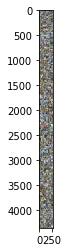

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
# print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Sequential(
          nn.Conv2d(3, 32, 3),
          nn.ReLU(),
          nn.Conv2d(32, 32, 3),
          nn.ReLU(),
          nn.MaxPool2d(2, 2),
          nn.Dropout(0.2)
        )

        self.layer2 = torch.nn.Sequential(
          nn.Conv2d(32, 64, 3),
          nn.ReLU(),
          nn.Conv2d(64, 64, 3),
          nn.ReLU(),
          nn.MaxPool2d(2, 2),
          nn.Dropout(0.2)
        )


        self.fc1 = nn.Linear(1600, 120)
        self.bn1 = nn.BatchNorm1d(120)
        self.bn2 = nn.BatchNorm1d(84)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)


    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = torch.flatten(x, 1) # 배치를 제외한 모든 차원을 평탄화(flatten)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x


net = Net()

if torch.cuda.device_count() > 1:
    net = nn.DataParallel(net)

net.to(device)

DataParallel(
  (module): Net(
    (layer1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Dropout(p=0.2, inplace=False)
    )
    (layer2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Dropout(p=0.2, inplace=False)
    )
    (fc1): Linear(in_features=1600, out_features=120, bias=True)
    (bn1): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc2): Linear(in_features=120, out_features=84, bias=True)
    (fc3): Linear(in_feat

In [7]:
# 모델의 state_dict 출력
print("Model's state_dict:")
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())


Model's state_dict:
module.layer1.0.weight 	 torch.Size([32, 3, 3, 3])
module.layer1.0.bias 	 torch.Size([32])
module.layer1.2.weight 	 torch.Size([32, 32, 3, 3])
module.layer1.2.bias 	 torch.Size([32])
module.layer2.0.weight 	 torch.Size([64, 32, 3, 3])
module.layer2.0.bias 	 torch.Size([64])
module.layer2.2.weight 	 torch.Size([64, 64, 3, 3])
module.layer2.2.bias 	 torch.Size([64])
module.fc1.weight 	 torch.Size([120, 1600])
module.fc1.bias 	 torch.Size([120])
module.bn1.weight 	 torch.Size([120])
module.bn1.bias 	 torch.Size([120])
module.bn1.running_mean 	 torch.Size([120])
module.bn1.running_var 	 torch.Size([120])
module.bn1.num_batches_tracked 	 torch.Size([])
module.bn2.weight 	 torch.Size([84])
module.bn2.bias 	 torch.Size([84])
module.bn2.running_mean 	 torch.Size([84])
module.bn2.running_var 	 torch.Size([84])
module.bn2.num_batches_tracked 	 torch.Size([])
module.fc2.weight 	 torch.Size([84, 120])
module.fc2.bias 	 torch.Size([84])
module.fc3.weight 	 torch.Size([10, 84])
m

In [8]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [9]:
net.train()
for epoch in range(200):   # 데이터셋을 수차례 반복합니다.
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data[0].to(device), data[1].to(device)

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

print('Finished Training')

/home/ubuntu/anaconda3/envs/union2/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,    10] loss: 2.134
[1,    20] loss: 1.811
[1,    30] loss: 1.650
[1,    40] loss: 1.538
[2,    10] loss: 1.361
[2,    20] loss: 1.286
[2,    30] loss: 1.243
[2,    40] loss: 1.177
[3,    10] loss: 1.078
[3,    20] loss: 1.058
[3,    30] loss: 1.035
[3,    40] loss: 1.007
[4,    10] loss: 0.919
[4,    20] loss: 0.903
[4,    30] loss: 0.912
[4,    40] loss: 0.886
[5,    10] loss: 0.835
[5,    20] loss: 0.809
[5,    30] loss: 0.790
[5,    40] loss: 0.807
[6,    10] loss: 0.753
[6,    20] loss: 0.730
[6,    30] loss: 0.745
[6,    40] loss: 0.713
[7,    10] loss: 0.677
[7,    20] loss: 0.677
[7,    30] loss: 0.671
[7,    40] loss: 0.679
[8,    10] loss: 0.617
[8,    20] loss: 0.641
[8,    30] loss: 0.633
[8,    40] loss: 0.640
[9,    10] loss: 0.570
[9,    20] loss: 0.591
[9,    30] loss: 0.604
[9,    40] loss: 0.588
[10,    10] loss: 0.556
[10,    20] loss: 0.535
[10,    30] loss: 0.548
[10,    40] loss: 0.584
[11,    10] loss: 0.511
[11,    20] loss: 0.508
[11,    30] loss: 0.526
[11,

[86,    40] loss: 0.102
[87,    10] loss: 0.101
[87,    20] loss: 0.104
[87,    30] loss: 0.097
[87,    40] loss: 0.097
[88,    10] loss: 0.096
[88,    20] loss: 0.091
[88,    30] loss: 0.098
[88,    40] loss: 0.102
[89,    10] loss: 0.095
[89,    20] loss: 0.101
[89,    30] loss: 0.100
[89,    40] loss: 0.097
[90,    10] loss: 0.089
[90,    20] loss: 0.100
[90,    30] loss: 0.104
[90,    40] loss: 0.099
[91,    10] loss: 0.093
[91,    20] loss: 0.094
[91,    30] loss: 0.093
[91,    40] loss: 0.100
[92,    10] loss: 0.090
[92,    20] loss: 0.093
[92,    30] loss: 0.097
[92,    40] loss: 0.104
[93,    10] loss: 0.091
[93,    20] loss: 0.091
[93,    30] loss: 0.083
[93,    40] loss: 0.094
[94,    10] loss: 0.095
[94,    20] loss: 0.091
[94,    30] loss: 0.092
[94,    40] loss: 0.093
[95,    10] loss: 0.092
[95,    20] loss: 0.095
[95,    30] loss: 0.097
[95,    40] loss: 0.088
[96,    10] loss: 0.091
[96,    20] loss: 0.079
[96,    30] loss: 0.091
[96,    40] loss: 0.100
[97,    10] loss

[169,    20] loss: 0.065
[169,    30] loss: 0.057
[169,    40] loss: 0.070
[170,    10] loss: 0.064
[170,    20] loss: 0.069
[170,    30] loss: 0.066
[170,    40] loss: 0.067
[171,    10] loss: 0.067
[171,    20] loss: 0.062
[171,    30] loss: 0.063
[171,    40] loss: 0.068
[172,    10] loss: 0.065
[172,    20] loss: 0.070
[172,    30] loss: 0.066
[172,    40] loss: 0.069
[173,    10] loss: 0.062
[173,    20] loss: 0.071
[173,    30] loss: 0.065
[173,    40] loss: 0.067
[174,    10] loss: 0.067
[174,    20] loss: 0.061
[174,    30] loss: 0.065
[174,    40] loss: 0.063
[175,    10] loss: 0.068
[175,    20] loss: 0.065
[175,    30] loss: 0.069
[175,    40] loss: 0.072
[176,    10] loss: 0.064
[176,    20] loss: 0.069
[176,    30] loss: 0.067
[176,    40] loss: 0.065
[177,    10] loss: 0.055
[177,    20] loss: 0.071
[177,    30] loss: 0.068
[177,    40] loss: 0.071
[178,    10] loss: 0.065
[178,    20] loss: 0.054
[178,    30] loss: 0.065
[178,    40] loss: 0.065
[179,    10] loss: 0.065


In [10]:
PATH = './cifar10_net_weight_pruning_test.pth'
torch.save(net.state_dict(), PATH)

In [11]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
# 이미지를 출력합니다.
# imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(64)))

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship   dog horse  ship  frog horse plane  deer truck   dog  bird  deer plane truck  frog  frog   dog  deer   dog truck  bird  deer   car truck   dog  deer  frog   dog  frog plane truck   cat truck horse  frog truck  ship plane   cat  ship  ship horse horse  deer  frog horse   cat  frog   cat


In [12]:
net = Net()
if torch.cuda.device_count() > 1:
    net = nn.DataParallel(net)
net.to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [13]:
net.eval()
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = net(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 79 %


In [14]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 82.9 %
Accuracy for class car   is: 89.9 %
Accuracy for class bird  is: 65.9 %
Accuracy for class cat   is: 57.9 %
Accuracy for class deer  is: 76.5 %
Accuracy for class dog   is: 69.9 %
Accuracy for class frog  is: 82.9 %
Accuracy for class horse is: 86.5 %
Accuracy for class ship  is: 88.3 %
Accuracy for class truck is: 90.3 %


In [15]:
def cut_node(torch_layer, percent):
    #정렬된 weight(절댓값 기준)
    abs_sort_result = torch.abs(torch_layer).view(-1).sort()
    cut_off_index = int(len(abs_sort_result.values) * percent)
    cut_off_value = abs_sort_result.values[cut_off_index-1]
    return torch.where(torch.abs(torch_layer) > cut_off_value, torch_layer, torch.zeros(torch_layer.size(),dtype=torch.float32).cuda())

In [16]:
#80퍼센트 pruning

In [17]:
net = Net()
if torch.cuda.device_count() > 1:
    net = nn.DataParallel(net)
net.to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [18]:
percent = 0.8
for name, param in net.named_parameters():
    if "weight" in name:       
        cut = cut_node(param,percent)
        net.state_dict()[name].data.copy_(cut)

In [19]:
net.eval()
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = net(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 9 %


In [20]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 0.0 %
Accuracy for class car   is: 0.0 %
Accuracy for class bird  is: 0.0 %
Accuracy for class cat   is: 0.0 %
Accuracy for class deer  is: 0.0 %
Accuracy for class dog   is: 95.0 %
Accuracy for class frog  is: 2.9 %
Accuracy for class horse is: 0.1 %
Accuracy for class ship  is: 0.0 %
Accuracy for class truck is: 0.0 %


In [21]:
#50퍼센트 pruning

In [22]:
net = Net()
if torch.cuda.device_count() > 1:
    net = nn.DataParallel(net)
net.to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [23]:
percent = 0.5
for name, param in net.named_parameters():
    if "weight" in name:       
        cut = cut_node(param,percent)
        net.state_dict()[name].data.copy_(cut)

In [24]:
net.eval()
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = net(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 39 %


In [25]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 46.9 %
Accuracy for class car   is: 67.5 %
Accuracy for class bird  is: 9.5 %
Accuracy for class cat   is: 6.3 %
Accuracy for class deer  is: 4.8 %
Accuracy for class dog   is: 77.5 %
Accuracy for class frog  is: 73.5 %
Accuracy for class horse is: 25.0 %
Accuracy for class ship  is: 24.9 %
Accuracy for class truck is: 61.1 %


In [26]:
#25퍼센트 pruning

In [27]:
net = Net()
if torch.cuda.device_count() > 1:
    net = nn.DataParallel(net)
net.to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [28]:
percent = 0.25
for name, param in net.named_parameters():
    if "weight" in name:       
        cut = cut_node(param,percent)
        net.state_dict()[name].data.copy_(cut)

In [29]:
net.eval()
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = net(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 69 %


In [30]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 78.7 %
Accuracy for class car   is: 88.3 %
Accuracy for class bird  is: 52.2 %
Accuracy for class cat   is: 38.9 %
Accuracy for class deer  is: 66.8 %
Accuracy for class dog   is: 68.8 %
Accuracy for class frog  is: 65.4 %
Accuracy for class horse is: 75.0 %
Accuracy for class ship  is: 82.3 %
Accuracy for class truck is: 81.4 %


In [31]:
#15퍼센트 pruning

In [32]:
net = Net()
if torch.cuda.device_count() > 1:
    net = nn.DataParallel(net)
net.to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [33]:
percent = 0.15
for name, param in net.named_parameters():
    if "weight" in name:       
        cut = cut_node(param,percent)
        net.state_dict()[name].data.copy_(cut)

In [34]:
net.eval()
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = net(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 75 %


In [35]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 78.2 %
Accuracy for class car   is: 88.4 %
Accuracy for class bird  is: 55.1 %
Accuracy for class cat   is: 58.0 %
Accuracy for class deer  is: 66.4 %
Accuracy for class dog   is: 67.4 %
Accuracy for class frog  is: 79.5 %
Accuracy for class horse is: 85.3 %
Accuracy for class ship  is: 85.8 %
Accuracy for class truck is: 87.8 %


In [36]:
#10퍼센트 pruning

In [37]:
net = Net()
if torch.cuda.device_count() > 1:
    net = nn.DataParallel(net)
net.to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [38]:
percent = 0.10
for name, param in net.named_parameters():
    if "weight" in name:       
        cut = cut_node(param,percent)
        net.state_dict()[name].data.copy_(cut)
        print(name)

module.layer1.0.weight
module.layer1.2.weight
module.layer2.0.weight
module.layer2.2.weight
module.fc1.weight
module.bn1.weight
module.bn2.weight
module.fc2.weight
module.fc3.weight


In [39]:
global_parameters_count = 0
global_zero_parameters_count = 0
for name, param in net.named_parameters():
    if "weight" in name:       
        loclal_parameters_count = param.nelement()
        local_zero_parameters_count = torch.sum(param == 0)
        global_parameters_count += loclal_parameters_count
        global_zero_parameters_count += local_zero_parameters_count

global_zero_parameters_count = int(global_zero_parameters_count)
print(int(global_zero_parameters_count))
print(global_parameters_count)


26848
268500


In [40]:
net.eval()
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = net(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 76 %


In [41]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 76.1 %
Accuracy for class car   is: 88.8 %
Accuracy for class bird  is: 62.6 %
Accuracy for class cat   is: 55.8 %
Accuracy for class deer  is: 65.9 %
Accuracy for class dog   is: 68.6 %
Accuracy for class frog  is: 83.7 %
Accuracy for class horse is: 81.7 %
Accuracy for class ship  is: 88.7 %
Accuracy for class truck is: 90.0 %


In [57]:
#2퍼센트 pruning

In [58]:
net = Net()
if torch.cuda.device_count() > 1:
    net = nn.DataParallel(net)
net.to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [59]:
percent = 0.02
for name, param in net.named_parameters():
    if "weight" in name:       
        cut = cut_node(param,percent)
        net.state_dict()[name].data.copy_(cut)
        print(name)

module.layer1.0.weight
module.layer1.2.weight
module.layer2.0.weight
module.layer2.2.weight
module.fc1.weight
module.bn1.weight
module.bn2.weight
module.fc2.weight
module.fc3.weight


In [60]:
global_parameters_count = 0
global_zero_parameters_count = 0
for name, param in net.named_parameters():
    if "weight" in name:       
        loclal_parameters_count = param.nelement()
        local_zero_parameters_count = torch.sum(param == 0)
        global_parameters_count += loclal_parameters_count
        global_zero_parameters_count += local_zero_parameters_count
        print(int(local_zero_parameters_count))
        print(loclal_parameters_count)

global_zero_parameters_count = int(global_zero_parameters_count)
print(int(global_zero_parameters_count))
print(global_parameters_count)


17
864
184
9216
368
18432
737
36864
3840
192000
2
120
1
84
201
10080
16
840
5366
268500


In [61]:
net.eval()
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = net(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 78 %


In [62]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 83.6 %
Accuracy for class car   is: 88.1 %
Accuracy for class bird  is: 65.3 %
Accuracy for class cat   is: 61.1 %
Accuracy for class deer  is: 74.3 %
Accuracy for class dog   is: 65.3 %
Accuracy for class frog  is: 83.5 %
Accuracy for class horse is: 87.2 %
Accuracy for class ship  is: 86.8 %
Accuracy for class truck is: 91.5 %


In [63]:
#1퍼센트 pruning

In [64]:
net = Net()
if torch.cuda.device_count() > 1:
    net = nn.DataParallel(net)
net.to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [65]:
percent = 0.01
for name, param in net.named_parameters():
    if "weight" in name:       
        cut = cut_node(param,percent)
        net.state_dict()[name].data.copy_(cut)
        print(name)

module.layer1.0.weight
module.layer1.2.weight
module.layer2.0.weight
module.layer2.2.weight
module.fc1.weight
module.bn1.weight
module.bn2.weight
module.fc2.weight
module.fc3.weight


In [66]:
global_parameters_count = 0
global_zero_parameters_count = 0
for name, param in net.named_parameters():
    if "weight" in name:       
        loclal_parameters_count = param.nelement()
        local_zero_parameters_count = torch.sum(param == 0)
        global_parameters_count += loclal_parameters_count
        global_zero_parameters_count += local_zero_parameters_count
        print(int(local_zero_parameters_count))
        print(loclal_parameters_count)

global_zero_parameters_count = int(global_zero_parameters_count)
print(int(global_zero_parameters_count))
print(global_parameters_count)


8
864
92
9216
184
18432
368
36864
1920
192000
1
120
84
84
100
10080
8
840
2765
268500


In [67]:
net.eval()
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = net(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 10 %


In [68]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 100.0 %
Accuracy for class car   is: 0.0 %
Accuracy for class bird  is: 0.0 %
Accuracy for class cat   is: 0.0 %
Accuracy for class deer  is: 0.0 %
Accuracy for class dog   is: 0.0 %
Accuracy for class frog  is: 0.0 %
Accuracy for class horse is: 0.0 %
Accuracy for class ship  is: 0.0 %
Accuracy for class truck is: 0.0 %


In [121]:
#0퍼센트 pruning

In [122]:
net = Net()
if torch.cuda.device_count() > 1:
    net = nn.DataParallel(net)
net.to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [123]:
percent = 0.00
for name, param in net.named_parameters():
    if "weight" in name:       
        cut = cut_node(param,percent)
        net.state_dict()[name].data.copy_(cut)
        print(name)

module.layer1.0.weight
module.layer1.2.weight
module.layer2.0.weight
module.layer2.2.weight
module.fc1.weight
module.bn1.weight
module.bn2.weight
module.fc2.weight
module.fc3.weight


In [124]:
global_parameters_count = 0
global_zero_parameters_count = 0
for name, param in net.named_parameters():
    if "weight" in name:       
        loclal_parameters_count = param.nelement()
        local_zero_parameters_count = torch.sum(param == 0)
        global_parameters_count += loclal_parameters_count
        global_zero_parameters_count += local_zero_parameters_count
        print(int(local_zero_parameters_count))
        print(loclal_parameters_count)

global_zero_parameters_count = int(global_zero_parameters_count)
print(int(global_zero_parameters_count))
print(global_parameters_count)


864
864
9216
9216
18432
18432
36864
36864
192000
192000
120
120
84
84
10080
10080
840
840
268500
268500


In [125]:
net.eval()
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = net(images)
        print(outputs.size())
        print(outputs[:2])
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

torch.Size([1024, 10])
tensor([[ 0.0896, -0.1501, -0.0386, -0.1110, -0.1103,  0.1418,  0.0755, -0.0124,
          0.0092, -0.0404],
        [ 0.0896, -0.1501, -0.0386, -0.1110, -0.1103,  0.1418,  0.0755, -0.0124,
          0.0092, -0.0404]], device='cuda:0')
torch.Size([1024, 10])
tensor([[ 0.0896, -0.1501, -0.0386, -0.1110, -0.1103,  0.1418,  0.0755, -0.0124,
          0.0092, -0.0404],
        [ 0.0896, -0.1501, -0.0386, -0.1110, -0.1103,  0.1418,  0.0755, -0.0124,
          0.0092, -0.0404]], device='cuda:0')
torch.Size([1024, 10])
tensor([[ 0.0896, -0.1501, -0.0386, -0.1110, -0.1103,  0.1418,  0.0755, -0.0124,
          0.0092, -0.0404],
        [ 0.0896, -0.1501, -0.0386, -0.1110, -0.1103,  0.1418,  0.0755, -0.0124,
          0.0092, -0.0404]], device='cuda:0')
torch.Size([1024, 10])
tensor([[ 0.0896, -0.1501, -0.0386, -0.1110, -0.1103,  0.1418,  0.0755, -0.0124,
          0.0092, -0.0404],
        [ 0.0896, -0.1501, -0.0386, -0.1110, -0.1103,  0.1418,  0.0755, -0.0124,
          

In [126]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 0.0 %
Accuracy for class car   is: 0.0 %
Accuracy for class bird  is: 0.0 %
Accuracy for class cat   is: 0.0 %
Accuracy for class deer  is: 0.0 %
Accuracy for class dog   is: 100.0 %
Accuracy for class frog  is: 0.0 %
Accuracy for class horse is: 0.0 %
Accuracy for class ship  is: 0.0 %
Accuracy for class truck is: 0.0 %
